# Olfaction data analysis

This notebook demonstrates how to reproduce the essential elements of Fig. 3 in:

> [**Discovering precise temporal patterns in large-scale neural recordings through robust and interpretable time warping**](https://doi.org/10.1016/j.neuron.2019.10.020). Williams AH, Poole B, Maheswaranathan N, Dhawale AK, Fisher T, Wilson CD, Brann DH, Trautmann E, Ryu S, Shusterman R, Rinberg D, Ölveczky BP, Shenoy KV, Ganguli S (2020). *Neuron*. 105(2):246-259.e8

These data were collected by Chris Wilson in Dmitry Rinberg's lab, and are described in detail in the following paper, which should be cited if these data are re-used.

> [**A primacy code for odor identity**](https://www.nature.com/articles/s41467-017-01432-4). Wilson CD, Serrano GO, Koulakov AA, Rinberg D (2017). *Nature Communications*. 8:1477

Further questions regarding this data should be directed to rinberg@nyu.edu

In [188]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
%matplotlib inline

#### Load Data

In [189]:
# Raw data 
dat = sio.loadmat('pydict_JEB7_2021-04-29.mat')

# Construct Z
Z = dict()
Z['trials'] = dat['trials'].reshape(-1)
Z['spiketimes'] = dat['spiketimes'].reshape(-1)
Z['noshiftspiketimes'] = dat['noshiftspiketimes'].reshape(-1)
Z['neuron_ids'] = dat['neuron_ids'].reshape(-1)
Z['tmin'] = np.array(dat['tmin'].item())
Z['tmax'] = np.array(dat['tmax'].item())
Z['shifts'] = dat['shifts'].reshape(-1)


# Spiking data.
from affinewarp import SpikeData
data = SpikeData(
    Z["trials"],
    Z["spiketimes"],
    Z["neuron_ids"],
    tmin=Z["tmin"],
    tmax=Z["tmax"],
)

# Encode sniff onsets as a fraction between zero (stim onset) and one (trial end).
frac_onsets = (Z["shifts"]-Z["tmin"]) / (Z["tmax"]-Z['tmin'])

In [190]:
frac_onsets

array([0.53280387, 0.52433682, 0.56593335, 0.53134017, 0.49147711,
       0.47318978, 0.58583116, 0.51812431, 0.57397668, 0.48504157,
       0.59706409, 0.57501231, 0.54144142, 0.57361531, 0.57134043,
       0.55576137, 0.55612632, 0.49934013, 0.54859549, 0.51840509,
       0.49244215, 0.55585377, 0.52275373, 0.57050131, 0.56684718,
       0.50469822, 0.56025619, 0.64029075, 0.57040426, 0.5414057 ,
       0.53170455, 0.521928  , 0.52818453, 0.48437336, 0.53736622,
       0.59134665, 0.48476473, 0.50467602, 0.51941503, 0.55614288,
       0.56469474, 0.46414277, 0.53832793, 0.51356901, 0.62943423,
       0.43684425, 0.50052642, 0.50685645, 0.51392374, 0.54513409,
       0.46031641, 0.58417347, 0.48090897, 0.54444226, 0.52822211,
       0.47431353, 0.48634107, 0.60016637, 0.5866929 , 0.48619787,
       0.53698864, 0.50220235, 0.54419294, 0.50488548, 0.57079159,
       0.57764785, 0.57247538, 0.54617793, 0.50254625, 0.58010958,
       0.5099961 , 0.60681791, 0.53525399, 0.5513922 , 0.57048

In [191]:
Z

{'trials': array([ 0,  0,  0, ..., 77, 77, 77], dtype=uint8),
 'spiketimes': array([-0.19010066, -0.08250066, -0.04174066, ...,  6.36986194,
         6.64630194,  6.74878194]),
 'noshiftspiketimes': array([-0.35412, -0.24652, -0.20576, ...,  6.05772,  6.33416,  6.43664]),
 'neuron_ids': array([ 1,  1,  1, ..., 30, 30, 30], dtype=uint8),
 'tmin': array(0),
 'tmax': array(5),
 'shifts': array([2.66401934, 2.62168412, 2.82966675, 2.65670086, 2.45738556,
        2.36594888, 2.92915581, 2.59062156, 2.86988342, 2.42520785,
        2.98532043, 2.87506156, 2.70720708, 2.86807653, 2.85670215,
        2.77880683, 2.78063162, 2.49670065, 2.74297743, 2.59202543,
        2.46221077, 2.77926883, 2.61376866, 2.85250656, 2.83423588,
        2.52349112, 2.80128095, 3.20145375, 2.85202129, 2.7070285 ,
        2.65852275, 2.60964002, 2.64092264, 2.42186682, 2.68683111,
        2.95673326, 2.42382367, 2.52338008, 2.59707515, 2.78071442,
        2.82347368, 2.32071387, 2.69163965, 2.56784503, 3.14717115,
 

In [192]:
print(Z['trials'].shape)
print(Z['spiketimes'].shape)
print(Z['neuron_ids'].shape)

print('Number of Trials:   ', len(np.unique(Z['trials'])))
print('Number of Neurons:  ', len(np.unique(Z['neuron_ids'])))

(151865,)
(151865,)
(151865,)
Number of Trials:    78
Number of Neurons:   30


In [194]:
data # a SpikeData object

#### Hyperparameters (can be fiddled with)

In [195]:
NBINS = 500         # Number of time bins per trial
SMOOTH_REG = 10.0   # Strength of roughness penalty
WARP_REG = 0.0      # Strength of penalty on warp magnitude
L2_REG = 0.0        # Strength of L2 penalty on template magnitude
MAXLAG = 0.5         # Maximum amount of shift allowed.

In [196]:
# Specify model.
from affinewarp import ShiftWarping
shift_model = ShiftWarping(
    maxlag=MAXLAG,
    smoothness_reg_scale=SMOOTH_REG,
    warp_reg_scale=WARP_REG,
    l2_reg_scale=L2_REG,
)

# Fit and apply warping to held out neurons.
from affinewarp.crossval import heldout_transform
validated_alignments = heldout_transform(
    shift_model, data.bin_spikes(NBINS), data, iterations=100)

# Fit model to full dataset (used to align sniffs).
shift_model.fit(data.bin_spikes(NBINS))

# NOTE: various preprocessing and normalizations schemes (z-scoring,
# square-root-transforming the spike counts, etc.) could be tried here.

Loss: 0.07: 100%|██████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.31it/s]


In [197]:
validated_alignments.shape # (trials, time, neurons)

(78, 5, 31)

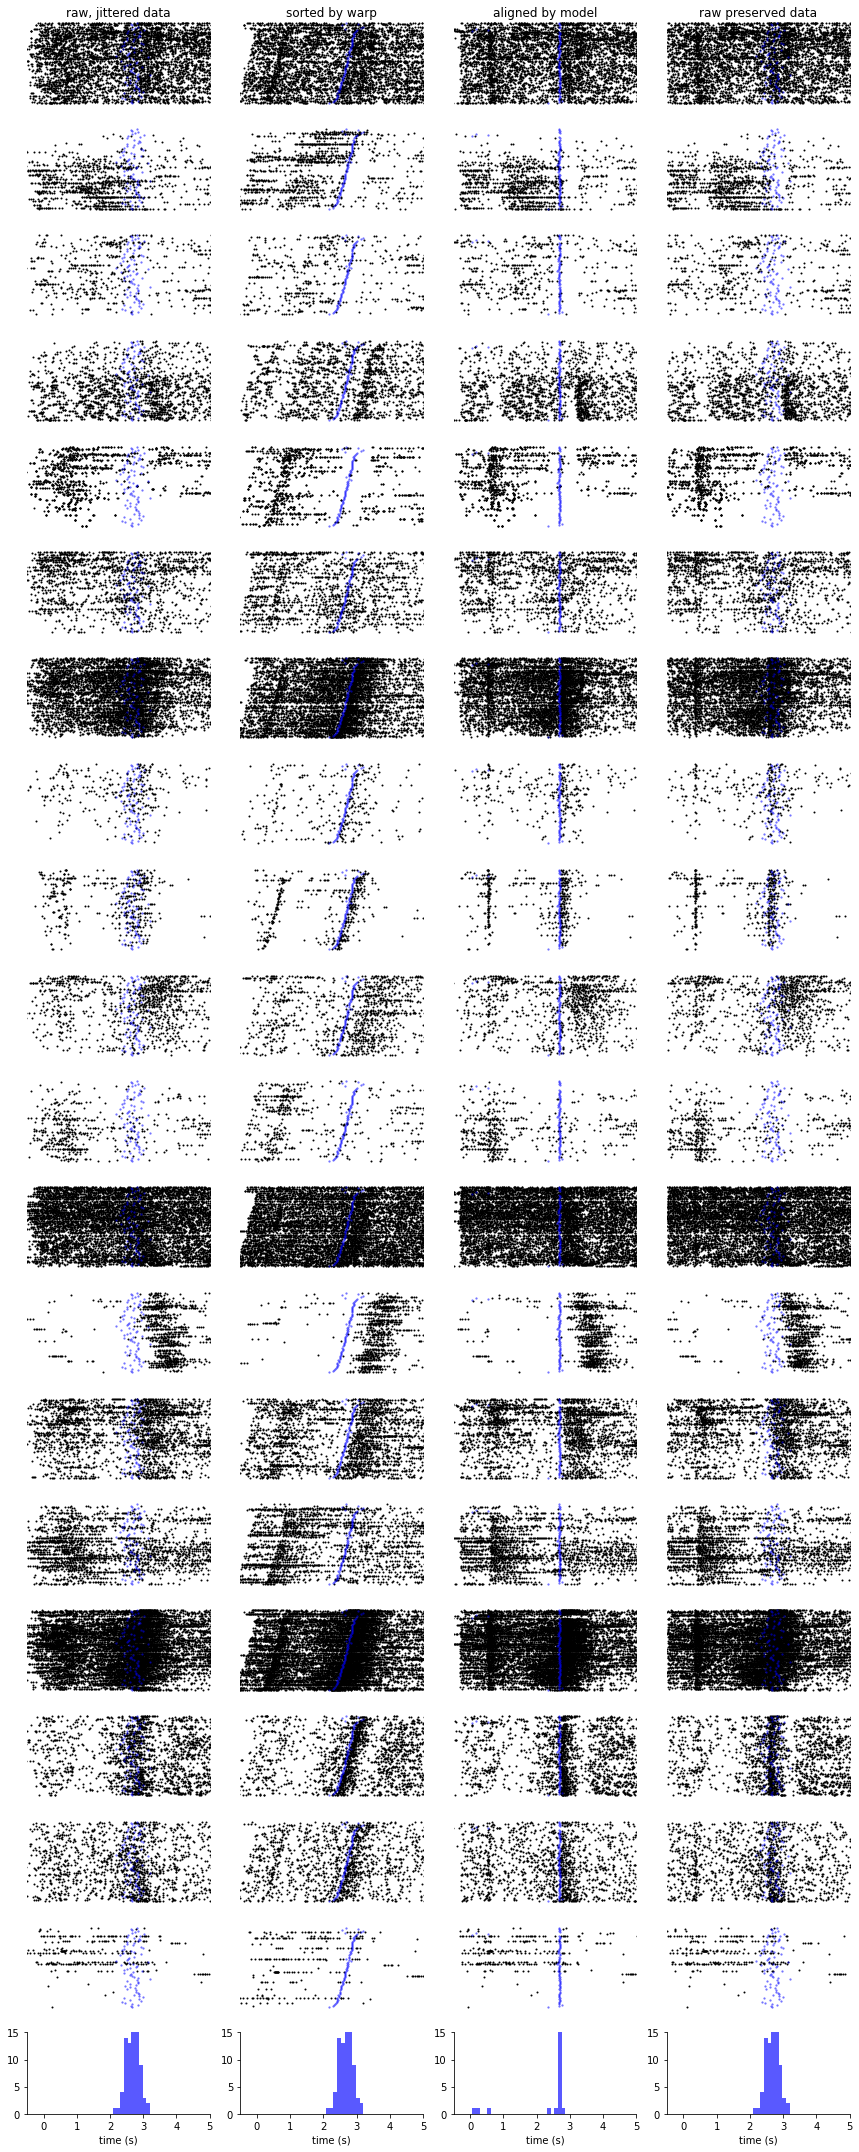

In [205]:
def _plot_column(axc, spks, sniffs):
    """
    Plots column of subplots.
    
    Parameters
    ----------
    axc : array, holding list of axes in column.
    spks : SpikeData object
    sniffs : array, holding sniff time on each trial.
    """
    
    # These are the neurons shown in the paper.
    example_neurons = np.arange(1,20)

    # Plot raster plot for each neuron.
    raster_kws = dict(s=4, c='k', lw=0)
    for n, ax in zip(example_neurons, axc[:-1]):
        ax.scatter(
            spks.spiketimes[spks.neurons == n],
            spks.trials[spks.neurons == n],
            **raster_kws,
        )
        ax.set_ylim(-1, len(sniffs))
        ax.axis('off')

        # Plot blue dots, denoting sniffs, on rasters.
        sniff_kws = dict(c='b', s=5, alpha=.55, lw=0)
        ax.scatter(sniffs, range(sniffs.size), **sniff_kws)

    # Plot histogram at bottom.
    histbins = np.linspace(-0.5, 5, 50)
    axc[-1].hist(sniffs, histbins, color='blue', alpha=.65)
    
    # Format bottom subplot.
    axc[-1].spines['right'].set_visible(False)
    axc[-1].spines['top'].set_visible(False)
    axc[-1].set_ylim(0, 15)


# Create figure.
fig, axes = plt.subplots(20, 4, figsize=(12,30))


# First column, raw data.
_plot_column(
    axes[:, 0], data, Z["shifts"]
)


# Second column, re-sorted trials by warping function.
_plot_column(
    axes[:, 1],
    data.reorder_trials(shift_model.argsort_warps()),
    Z["shifts"][shift_model.argsort_warps()]
)


# Third column, shifted alignment.
_plot_column(
    axes[:, 2],
    validated_alignments,
    shift_model.event_transform(
        range(Z["shifts"].size), frac_onsets) * (Z["tmax"]-Z['tmin']),
)

# Fourth column, raw preserved data (aligned to go cue)
# These are the neurons shown in the paper.
example_neurons = np.arange(1,20)

# Plot raster plot for each neuron.
raster_kws = dict(s=4, c='k', lw=0)
for n, ax in zip(example_neurons, axes[:,3][:-1]):
    ax.scatter(
        Z['noshiftspiketimes'][Z['neuron_ids'] == n],
        Z['trials'][Z['neuron_ids'] == n],
        **raster_kws,
    )
    ax.set_ylim(-1, len(Z['shifts']))
    ax.axis('off')

    # Plot blue dots, denoting sniffs, on rasters.
    sniff_kws = dict(c='b', s=5, alpha=.55, lw=0)
    ax.scatter(Z['shifts'], range(Z['shifts'].size), **sniff_kws)

# Plot histogram at bottom.
histbins = np.linspace(-0.5, 5, 50)
axes[:,3][-1].hist(Z['shifts'], histbins, color='blue', alpha=.65)

# Format bottom subplot.
axes[:,3][-1].spines['right'].set_visible(False)
axes[:,3][-1].spines['top'].set_visible(False)
axes[:,3][-1].set_ylim(0, 15)


# Final formatting.
for ax in axes.ravel():
    ax.set_xlim(-0.5, 5)
for ax in axes[-1]:
    ax.set_xlabel("time (s)")

axes[0, 0].set_title("raw, jittered data")
axes[0, 1].set_title("sorted by warp")
axes[0, 2].set_title("aligned by model")
axes[0, 3].set_title("raw preserved data")

fig.tight_layout()
fig.subplots_adjust(hspace=.3)